# Classification
## MI201

##**Group 4** :
- Diego FLEURY CORRÊA DE MORAES
- Hazael SOLEDADE DE ARAUJO JUMONJI
- Lucas DE OLIVEIRA MARTIM

### Project 3 : **Sentiment Analysis Using LLMs**

In [1]:
# Data handling
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

# Ploting
import matplotlib.pyplot as plt
import seaborn as sns

# Text preprocessing
import re
import unicodedata

# BERT
from transformers import AutoTokenizer, AutoModel

# Deep learning
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim

# Metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Classic ML models
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Model selection
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_score

# Importing Data

In [2]:
train_full = pd.read_csv('processed_train.csv')
test_full = pd.read_csv('processed_test.csv')

X_train, X_val, y_train, y_val = train_test_split(train_full['Text'], train_full['Sentiment'], test_size=0.2, random_state=42)
X_test, y_test = test_full['Text'], test_full['Sentiment']

In [3]:
train_full.dropna(inplace=True)
test_full.dropna(inplace=True)

In [4]:
X_train.reset_index(drop=True, inplace=True)
X_val.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)

y_train.reset_index(drop=True, inplace=True)
y_val.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

In [5]:
# Preprocessing the text

def preprocess_text(text):
    """
    Text preprocessing, removing accents, links, HTML, extra spaces and user names.

    - Converts to lowercase.
    - Removes accents.
    - Removes HTML tags.
    - Remove links (http, https, www).
    - Removes extra spaces.
    - Removes user names.
    """

    if not isinstance(text, str):
        return ""

    # Lowercase
    text = text.lower()

    # Strip all accents
    text = ''.join(c for c in unicodedata.normalize('NFKD', text) if unicodedata.category(c) != 'Mn')

    # Removes links (http, https, www)
    text = re.sub(r"http\S+|www\S+", "", text)

    # Removes HTML tags
    text = re.sub(r"<.*?>", "", text)

    # Removes usernames
    text = re.sub(r"@\w+", "", text)

    # Removes line breaks and excessive whitespaces
    text = re.sub(r"\s+", " ", text).strip()

    return text

In [6]:
X_train = X_train.apply(preprocess_text)
X_val = X_val.apply(preprocess_text)
X_test = X_test.apply(preprocess_text)

In [7]:
sentiment_mapping = {'negative': 0, 'neutral': 1, 'positive': 2}
y_train = y_train.map(sentiment_mapping)
y_val = y_val.map(sentiment_mapping)
y_test = y_test.map(sentiment_mapping)

In [8]:
X_train

,Text
0,"oh, he`s hilarious. i`m just commenting on the..."
1,"thanks for trying i was hoping bud trillin, bu..."
2,after show at our house rocked! saying goodbye...
3,up at 4:30am west coast time..gettin ready to ...
4,my computer is so slooowww this morning. i thi...
...,...
21979,feels like warm things
21980,my best friend is in vegas without me
21981,- fire and urban at rock challenge
21982,a+ for effort though


In [9]:
y_train

,Sentiment
0,2
1,2
2,1
3,2
4,1
...,...
21979,1
21980,1
21981,1
21982,2


In [10]:
# Custom Dataset
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        """
        Args:
            texts (list): List of text samples.
            labels (list): List of sentiment labels (e.g., 0, 1).
            tokenizer (transformers.BertTokenizer): Tokenizer for BERT.
            max_length (int): Maximum length for tokenized sequences.
        """
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        # Tokenize and encode the text
        text = self.texts.iloc[idx]
        label = self.labels.iloc[idx]
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_length,
            return_tensors="pt"
        )
        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "label": torch.tensor(label, dtype=torch.long)
        }

# Extract embeddings for all data
def extract_embeddings(model, dataloader, device):
    """
    Extracts embeddings for all data using a pre-trained BERT model.

    Args:
        model (transformers.BertModel): Pre-trained BERT model.
        dataloader (DataLoader): DataLoader for the dataset.
        device (torch.device): Device to run the model on (CPU or GPU).

    Returns:
        torch.Tensor: A matrix of size (number_of_samples, embedding_size).
    """
    model.eval()  # Set the model to evaluation mode
    embeddings = []

    with torch.no_grad():  # Disable gradient computation
        for batch in dataloader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)

            # Forward pass through BERT
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            pooled_output = outputs.pooler_output  # CLS token representation

            # Append embeddings to the list
            embeddings.append(pooled_output.cpu())

    # Combine all embeddings into a single matrix
    return torch.cat(embeddings, dim=0)

# Custom Dataset
class EmbeddingDataset(Dataset):
    def __init__(self, embeddings, labels):
        """
        Args:
            texts (list): List of text samples.
            labels (list): List of sentiment labels (e.g., 0, 1).
            tokenizer (transformers.BertTokenizer): Tokenizer for BERT.
            max_length (int): Maximum length for tokenized sequences.
        """
        self.embeddings = embeddings
        self.labels = labels

    def __len__(self):
        return len(self.embeddings)

    def __getitem__(self, idx):
        # Tokenize and encode the text
        embeddings = self.embeddings[idx]
        label = self.labels[idx]

        return {
            "input_ids": embeddings,
            "label": torch.tensor(label, dtype=torch.long)
        }

In [11]:
# Hyperparameters
# PRETRAINED_MODEL = "bert-base-uncased"
PRETRAINED_MODEL = "cardiffnlp/twitter-roberta-base-sentiment"
MAX_LENGTH = 128
BATCH_SIZE = 64
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize tokenizer
tokenizer = AutoTokenizer.from_pretrained(PRETRAINED_MODEL)

# Initialize the datasets
train_dataset = TextDataset(X_train, y_train, tokenizer, MAX_LENGTH)
val_dataset = TextDataset(X_val, y_val, tokenizer, MAX_LENGTH)

# Initialize the dataloaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

train_embeddings = None
val_embeddings = None

load_embeddings = True

if not load_embeddings:
    # Get the bert model
    bert = AutoModel.from_pretrained(PRETRAINED_MODEL).to(device)

    # Extract embeddings (train)
    train_embeddings = extract_embeddings(bert, train_loader, device)
    train_embeddings =train_embeddings.cpu()

    # Extract embeddings (val)
    val_embeddings = extract_embeddings(bert, val_loader, device)
    val_embeddings =val_embeddings.cpu()

    # To save runtime next time
    np.save('roberta_train_embeddings.npy', train_embeddings)
    np.save('roberta_val_embeddings.npy', val_embeddings)
else:
    train_embeddings = np.load("roberta_train_embeddings.npy")
    val_embeddings = np.load("roberta_val_embeddings.npy")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

In [12]:
print("Valores únicos em y_train:", np.unique(y_train))
print("Tipo dos valores em y_train:", type(y_train[0]))

Valores únicos em y_train: [0 1 2]
Tipo dos valores em y_train: <class 'numpy.int64'>


In [13]:
train_embeddings.shape, val_embeddings.shape

((21984, 768), (5496, 768))

In [14]:
# Initialize the embedding datasets
embedding_train_dataset = EmbeddingDataset(train_embeddings, y_train)
embedding_val_dataset = EmbeddingDataset(val_embeddings, y_val)

# Initialize the embedding dataloaders
embedding_train_loader = DataLoader(embedding_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
embedding_val_loader = DataLoader(embedding_val_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Classical ML (SVM, Random Forest, XGBoost)

In [ ]:
# from sklearn.decomposition import PCA, KernelPCA

# # explained_variance_ratio = .99
# n_components = 50

# # Aplicar PCA nos embeddings de treino
# # pca = PCA(n_components=explained_variance_ratio)
# kpca = KernelPCA(n_components = n_components, kernel = "rbf")

# train_embeddings_pca = kpca.fit_transform(train_embeddings)

# # Transformar os embeddings de validação/teste com o mesmo PCA treinado
# val_embeddings_pca = kpca.transform(val_embeddings)
# # test_embeddings_pca = pca.transform(test_embeddings)

In [ ]:
! pip install umap-learn

In [ ]:
!pip install numba

In [ ]:
import umap
import numba

umap_model = umap.UMAP(n_components=50, n_neighbors=15, min_dist=0.1, metric = "cosine")
train_embeddings_umap = umap_model.fit_transform(train_embeddings)
val_embeddings_umap = umap_model.transform(val_embeddings)

In [ ]:
umap_model = umap.UMAP(n_components=50, n_neighbors=30, min_dist=0.1, metric = "cosine")
train_embeddings_umap = umap_model.fit_transform(train_embeddings)
val_embeddings_umap = umap_model.transform(val_embeddings)

In [ ]:
train_embeddings.shape, train_embeddings_umap.shape

### SVM

In [ ]:
from sklearn.linear_model import SGDClassifier

svm_sgd = SGDClassifier(loss='hinge', alpha=0.01, max_iter=2000, tol=1e-3)
svm_sgd.fit(train_embeddings_umap, y_train)

print(f"Accuracy: {svm_sgd.score(val_embeddings_umap, y_val):.4f}")


In [ ]:
from sklearn.svm import LinearSVC

svm = LinearSVC(C=1.0, max_iter=5000)
svm.fit(train_embeddings_umap, y_train)

print(f"Validation Accuracy: {svm.score(val_embeddings_umap, y_val):.4f}")


In [ ]:
from sklearn.linear_model import LogisticRegression

# Criar e treinar o modelo de Regressão Logística
logreg = LogisticRegression(
    max_iter=500,       # Número máximo de iterações para convergência
    C=1.0,              # Regularização (1.0 = padrão, pode ajustar)
    solver="lbfgs",     # Otimizador (funciona bem para embeddings grandes)
    multi_class="multinomial",  # Para classificação multiclasse
    n_jobs=-1           # Usa múltiplos núcleos da CPU
)

logreg.fit(train_embeddings_umap, y_train)

# Avaliação
accuracy = logreg.score(val_embeddings_umap, y_val)
print(f"Validation Accuracy: {accuracy:.4f}")

# Fazer previsões
logreg_predictions = logreg.predict(val_embeddings_umap)


In [ ]:
# svm_params = {
#     'C': [0.1, 1, 10],
#     'kernel': ['linear']
# }

# svm_grid = GridSearchCV(SVC(), svm_params, cv=3, n_jobs=-1, verbose=10)
# svm_grid.fit(train_embeddings_pca, y_train)

# print(f"Best parameters: {svm_grid.best_params_}")
# print(f"Best score: {svm_grid.best_score_}")

# svm_best_model = svm_grid.best_estimator_
# svm_best_model.fit(train_embeddings_pca, y_train)
# svm_predictions = svm_best_model.predict(val_embeddings_pca)

# generalization_error_estimate = 1 - svm_best_model.score(val_embeddings_pca, y_val)
# print(f"Generalization Error Estimate: {generalization_error_estimate}")

### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Criando e treinando o modelo Random Forest
rf = RandomForestClassifier(
    n_estimators=200,   # Número de árvores
    max_depth=10,       # Profundidade máxima das árvores (ajustável)
    n_jobs=-1,          # Usa todos os núcleos do processador
    random_state=42
)

rf.fit(train_embeddings_umap, y_train)

# Avaliação
accuracy = rf.score(val_embeddings_umap, y_val)
print(f"Validation Accuracy: {accuracy:.4f}")

# Fazer previsões
rf_predictions = rf.predict(val_embeddings_umap)


### XGBoost

In [ ]:
class_counts = np.bincount(y_train)

class_weights = {i: sum(class_counts) / class_counts[i] for i in range(len(class_counts))}

# Criar o vetor de pesos para cada amostra do y_train
sample_weights = np.array([class_weights[y] for y in y_train])

In [ ]:
class_weights

In [ ]:
from xgboost import XGBClassifier

# Criar e treinar o modelo XGBoost
xgb = XGBClassifier(
    n_estimators=100,  # Número de árvores na floresta
    max_depth=5,       # Profundidade máxima das árvores
    learning_rate=0.01, # Taxa de aprendizado
    use_label_encoder=False,  # Evita warnings desnecessários
    eval_metric="mlogloss",  # Métrica para classificação multiclasse
    sample_weight = sample_weights # Balanceamento das classes
)

xgb.fit(train_embeddings_umap, y_train)

# Avaliação no conjunto de validação
accuracy = xgb.score(val_embeddings_umap, y_val)
print(f"Validation Accuracy: {accuracy:.4f}")

# Neural Network

In [ ]:
# training script

def train( model, train_loader, optimizer, criterion, epoch,log_interval=50):
    model.train()

    loss_cpu=0
    correct = 0
    total = 0

    for batch_idx, data in enumerate(train_loader, 0):

        # get the inputs; data is a list of [inputs, labels]
        inputs, target = data['input_ids'],data['label']
        inputs, target = inputs.cuda(), target.cuda()

        # inputs =inputs.detach()
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, target)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient Clipping

        optimizer.step()

        _, predicted = torch.max(outputs.data, 1)
        loss_cpu+= loss.item()
        total += target.size(0)
        correct += predicted.eq(target.data).cpu().sum()

        if batch_idx % log_interval == 0:
            print('| Epoch [%3d/%3d] Iter[%3d/%3d]\t\tLoss: %.4f Acc@1: %.3f%%'
                %(epoch, EPOCHS, batch_idx+1,
                    (len(train_loader)//BATCH_SIZE)+1, loss.item(), 100.*correct/total))
            #n_iter=epoch * len(train_loader) + batch_idx

    return loss_cpu/len(train_loader)

# testing script
def test( model, test_loader, criterion ,epoch):
    model.eval()

    correct = 0
    total = 0
    test_loss = 0

    with torch.no_grad():
        for batch_idx, data in enumerate(test_loader, 0):
            inputs, target = data['input_ids'],data['label']
            inputs, target = inputs.cuda(), target.cuda()

            outputs  = model(inputs)
            loss = criterion(outputs,target)

            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += predicted.eq(target.data).cpu().sum()
            test_loss += loss.item()

    test_loss = test_loss/ len(test_loader)
    print("\n| Validation Epoch #%d\t\t\tLoss: %.4f Acc@1: %.2f%%" %(epoch, loss.item(), 100.*correct/total))
    return test_loss, 100.*correct/total

In [ ]:
class SentimentClassifier(nn.Module):
    def __init__(self, input_dim=768, hidden1=1024, hidden2=2048, output_dim=3, dropout=0.1):
        super(SentimentClassifier, self).__init__()

        # Camadas principais
        self.fc1 = nn.Linear(input_dim, hidden1)
        self.fc2 = nn.Linear(hidden1, hidden2)
        self.fc3 = nn.Linear(hidden2, hidden1)
        self.fc4 = nn.Linear(hidden1, input_dim)  # Aqui voltamos para 768
        self.fc_out = nn.Linear(input_dim, output_dim)  # Saída final (3 classes)

        # Dropout
        self.dropout = nn.Dropout(dropout)

        # Batch norm
        self.bn1 = nn.BatchNorm1d(hidden1)
        self.bn2 = nn.BatchNorm1d(hidden2)
        self.bn3 = nn.BatchNorm1d(hidden1)

        # Ativação
        self.activation = nn.GELU()

    def forward(self, x):
        skip = x  # Guardando a entrada para o skip connection

        x = self.fc1(x)
        x = self.bn1(x)
        x = self.activation(x)
        x = self.dropout(x)

        x = self.fc2(x)
        x = self.bn2(x)
        x = self.activation(x)
        x = self.dropout(x)

        x = self.fc3(x)
        x = self.bn3(x)
        x = self.activation(x)
        x = self.dropout(x)

        x = self.fc4(x)
        x = self.activation(x)

        x = x + skip  # Skip connection somando com a entrada original

        x = self.fc_out(x)
        return x  # Softmax será aplicado na loss function


In [ ]:
LEARNING_RATES = [2e-6]
EPOCHS = 60
PATIENCE = 7  # Número de épocas sem melhora antes de parar

# Listas para armazenar as perdas
all_train_losses = {}
all_val_losses = {}

for lr in LEARNING_RATES:

    print(f"\nTraining with lr = {lr}")

    model = SentimentClassifier().to(device)

    # Loss e otimizador
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)  # L2 Regularization leve
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=5)  # Redução gradual do LR

    train_losses = []
    val_losses = []

    best_val_loss = float("inf")
    patience_counter = 0

    # Loop de Treinamento
    for epoch in range(EPOCHS):
        train_loss = train(model, embedding_train_loader, optimizer, criterion, epoch)
        val_loss, val_acc = test(model, embedding_val_loader, criterion, epoch)

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        # Atualizar o Learning Rate com o Scheduler
        scheduler.step()

        # Early Stopping: Parar se a validação não melhorar por "PATIENCE" épocas
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0  # Reseta o contador de paciência
        else:
            patience_counter += 1
            if patience_counter >= PATIENCE:
                print(f"⏹️ Early Stopping ativado na época {epoch+1} para LR {lr}.")
                break  # Para o treinamento

    all_train_losses[f"LR {lr}"] = train_losses
    all_val_losses[f"LR {lr}"] = val_losses


Training with lr = 2e-06
| Epoch [  0/ 60] Iter[  1/  6]		Loss: 1.0838 Acc@1: 35.938%
| Epoch [  0/ 60] Iter[ 51/  6]		Loss: 0.8643 Acc@1: 64.951%
| Epoch [  0/ 60] Iter[101/  6]		Loss: 0.7855 Acc@1: 68.688%
| Epoch [  0/ 60] Iter[151/  6]		Loss: 0.6683 Acc@1: 70.085%
| Epoch [  0/ 60] Iter[201/  6]		Loss: 0.5711 Acc@1: 71.020%
| Epoch [  0/ 60] Iter[251/  6]		Loss: 0.6629 Acc@1: 71.470%
| Epoch [  0/ 60] Iter[301/  6]		Loss: 0.5718 Acc@1: 72.083%

| Validation Epoch #0			Loss: 0.5918 Acc@1: 74.56%
| Epoch [  1/ 60] Iter[  1/  6]		Loss: 0.6266 Acc@1: 76.562%
| Epoch [  1/ 60] Iter[ 51/  6]		Loss: 0.5470 Acc@1: 75.214%
| Epoch [  1/ 60] Iter[101/  6]		Loss: 0.5688 Acc@1: 75.309%
| Epoch [  1/ 60] Iter[151/  6]		Loss: 0.5269 Acc@1: 75.186%
| Epoch [  1/ 60] Iter[201/  6]		Loss: 0.7099 Acc@1: 75.140%
| Epoch [  1/ 60] Iter[251/  6]		Loss: 0.5684 Acc@1: 75.093%
| Epoch [  1/ 60] Iter[301/  6]		Loss: 0.6126 Acc@1: 75.099%

| Validation Epoch #1			Loss: 0.6239 Acc@1: 75.33%
| Epoch [  2/ 60

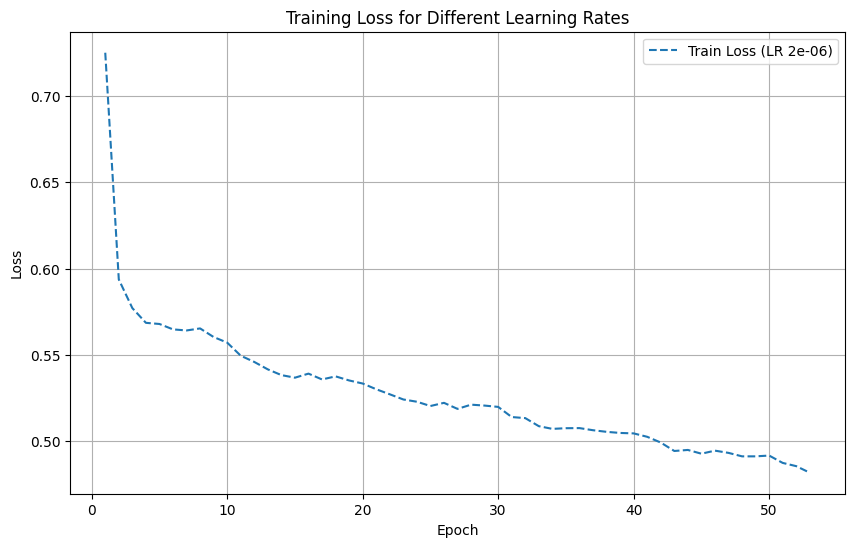

In [ ]:
# 📊 Plotando os resultados
plt.figure(figsize=(10, 6))

for lr, losses in all_train_losses.items():
    plt.plot(range(1, 53 + 1), losses, label=f"Train Loss ({lr})", linestyle="dashed")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss for Different Learning Rates")
plt.legend()
plt.grid()
plt.show()


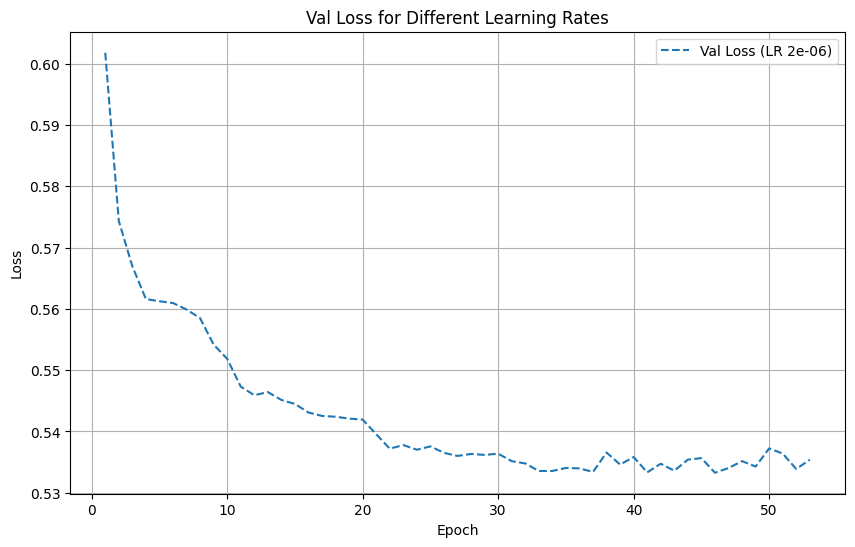

In [ ]:
# 📊 Plotando os resultados
plt.figure(figsize=(10, 6))

for lr, losses in all_val_losses.items():
    plt.plot(range(1, 53 + 1), losses, label=f"Val Loss ({lr})", linestyle="dashed")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Val Loss for Different Learning Rates")
plt.legend()
plt.grid()
plt.show()

# LLM

In [19]:
!pip install llamaapi

In [28]:
import json
from llamaapi import LlamaAPI
import requests
import time
from sklearn.metrics import confusion_matrix, classification_report

API_KEY = "LA-722439f7298347ab8eeddd84bae652ebc82098f0ae814b4eba9582cf7e8246d6"
URL = "https://api.llama-api.com"

llama = LlamaAPI(API_KEY)

MODEL_NAME = "llama3.1-70b"

def classify_tweet(tweet):
    api_request_json = {
        "model": MODEL_NAME,
        "messages": [
            {"role": "system", "content": "You are a sentiment classifier. Classify the sentiment of the given tweet as [positive, negative, neutral]. Please respond STICTLY with the classes (respect lower casing)"},
            {"role": "user", "content": f"Tweet: {tweet} \n Sentiment: "}
        ],
        "temperature": 0.1
    }

    response = llama.run(api_request_json)

    if response.status_code == 200:
        result = response.json()
        return result["choices"][0]["message"]["content"].strip()  # Retorna a resposta do modelo
    else:
        return f"Erro: {response.status_code}, {response.text}"

In [ ]:
# Let's just use a subset of the full dataset for practical purposes
llama_dataset = train_full.sample(n=30, random_state=42)

In [ ]:
# Listas para armazenar os resultados
true_labels = llama_dataset["Sentiment"].tolist()
predicted_labels = []

for tweet in llama_dataset["Text"]:

    try:
      sentiment = classify_tweet(tweet)
      predicted_labels.append(sentiment)
      print(f"📌 Tweet: {tweet} \n🟢 Predict: {sentiment} \n🔵 Real: {true_labels[len(predicted_labels)-1]}\n")
      time.sleep(2)
    except Exception as e:
        print(f"Error detected: {e}. Waiting 10 seconds before retry ...")
        time.sleep(10)

# Adicionar as previsões ao DataFrame
llama_dataset["Predicted"] = predicted_labels

# Calcular métricas de desempenho
accuracy = accuracy_score(true_labels, predicted_labels)
conf_matrix = confusion_matrix(true_labels, predicted_labels, labels=["positive", "negative", "neutral"])
report = classification_report(true_labels, predicted_labels, target_names=["positive", "negative", "neutral"])

print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(report)

# Plotar matriz de confusão
plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=["positive", "negative", "neutral"],
            yticklabels=["positive", "negative", "neutral"])
plt.xlabel("Predicted")
plt.ylabel("Real")
plt.title(f"Confusion Matrix - Sentiment Analysis ({MODEL_NAME}))")
plt.show()

📌 Tweet:  Enjoy! Family trumps everything 
🟢 Predict: positive 
🔵 Real: positive

📌 Tweet:  --of them kinda turns me off of it all.  And then I buy more of them and dig a deeper hole, etc. ;; 
🟢 Predict: negative 
🔵 Real: negative

📌 Tweet: Clive it`s my birthday pat me  http://apps.facebook.com/dogbook/profile/view/6386106 
🟢 Predict: positive 
🔵 Real: neutral

📌 Tweet:  congrats hey 
🟢 Predict: positive 
🔵 Real: positive

📌 Tweet: is texting 
🟢 Predict: neutral 
🔵 Real: neutral

📌 Tweet:  Do you have any idea when the (not so) patient fans will see some teaser pics of you all in costume? 
🟢 Predict: neutral 
🔵 Real: neutral

📌 Tweet:  Tell him where... 
🟢 Predict: neutral 
🔵 Real: neutral

📌 Tweet:  Ooooh, I`m jealous  I might try and get some for the saturday but I have an exam on the monday that Im gonna fail 
🟢 Predict: negative 
🔵 Real: negative

📌 Tweet:  OHSHNAPSSS. is she pissed at blair as usual ? hahah. & yeeeah, i bake cookies 
🟢 Predict: positive 
🔵 Real: neutral

📌 Tweet:

### Fine Tuning with LoRA